# Deep leanring: predicting stock price using LSTM

In [41]:
#imports necessary packages
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import mean_absolute_error, mean_squared_error

plt.style.use('fivethirtyeight')

In [42]:
start_date = datetime.datetime(2010,1,1)
end_date = datetime.datetime(2021,4,30)

data = yf.download('TSLA', start=start_date, end=end_date, group_by='ticker')

[*********************100%***********************]  1 of 1 completed


In [43]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [44]:
df = data.filter(['Adj Close'])
dataset = df.values
test_size = int(len(dataset)*.8) 

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [46]:
def sequence(seq, n_past, n_features):
    X, y = list(), list()
    size = len(seq)
    for i in range(size-n_past-n_features-1):
        X.append(seq[i:i+n_past+n_features, 0])
        y.append(seq[i+n_past+n_features, 0])
    return np.array(X), np.array(y)

In [47]:
#we split our data into training and testing
train_data = scaled_data[0:test_size,:]
test_data = scaled_data[test_size-60:,:]

#we prepare our data to be fitted
x_train, y_train = sequence(train_data, 60, 0)
x_test, y_test = sequence(test_data, 60, 0)

#we reshape data for the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [48]:
def LSTM_model(number_of_layer, number_of_units, input_shape, n_features):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=64, return_sequences=False))
    for i in range(number_of_layer):
        model.add(Dense(units=32))
    model.add(Dense(units=n_features))
    return model

model = LSTM_model(6,64,(x_train.shape[1],1), 1)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 32)               

In [49]:
history = model.fit(x_train, y_train, 
          epochs=15, 
          batch_size=32,
          validation_data = (x_test, y_test),
          verbose=1)

Epoch 1/15
67/67 [==============================] - 12s 102ms/step - loss: 5.0945e-04 - val_loss: 0.0036
Epoch 2/15
67/67 [==============================] - 6s 85ms/step - loss: 1.1486e-05 - val_loss: 0.0027
Epoch 3/15
67/67 [==============================] - 6s 83ms/step - loss: 1.1442e-05 - val_loss: 0.0043
Epoch 4/15
67/67 [==============================] - 6s 87ms/step - loss: 8.8353e-06 - val_loss: 0.0020
Epoch 5/15
67/67 [==============================] - 6s 87ms/step - loss: 8.6793e-06 - val_loss: 0.0033
Epoch 6/15
67/67 [==============================] - 6s 85ms/step - loss: 1.1750e-05 - val_loss: 0.0026
Epoch 7/15
67/67 [==============================] - 6s 86ms/step - loss: 9.7235e-06 - val_loss: 0.0026
Epoch 8/15
67/67 [==============================] - 6s 85ms/step - loss: 7.8669e-06 - val_loss: 0.0034
Epoch 9/15
67/67 [==============================] - 6s 87ms/step - loss: 1.0775e-05 - val_loss: 0.0034
Epoch 10/15
67/67 [==============================] - 6s 86ms/step - los

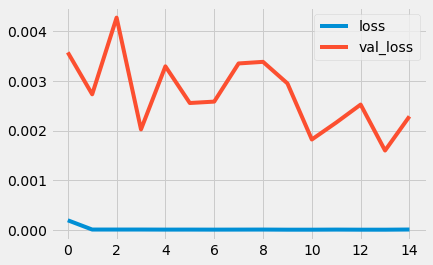

In [50]:
(pd.DataFrame(history.history)).plot()
plt.show()

In [51]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

accuracy = model.predict(x_train) 
accuracy = scaler.inverse_transform(accuracy)

In [52]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, predictions))

332.48821608647717

<ipython-input-53-7c87d23cf19f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


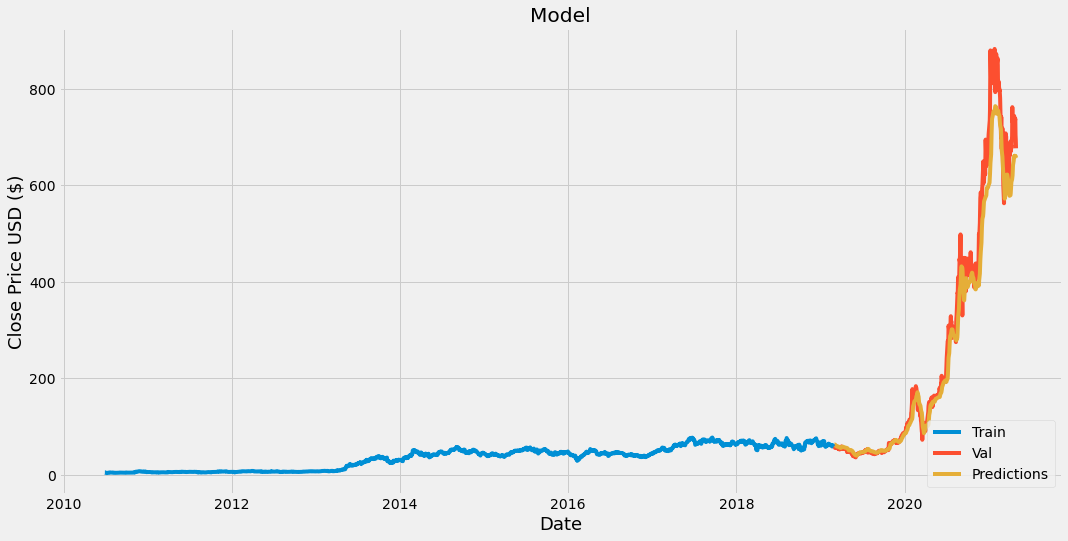

In [53]:
train = data[:test_size]
valid = data[test_size+1:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()